In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
NUM_EPOCHS = 10

In [2]:
train_data = MNIST(
    root = "data", 
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = MNIST(
    root = "data", 
    train = False,
    transform = ToTensor(),
    download = True
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net().to(device)

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train():
    model.train()
    total_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    print(f"  Train Loss: {train_loss:.4f}")
    return train_loss

def test():
    model.eval()
    correct = 0
    total_test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_test_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    test_loss = total_test_loss / len(test_loader)
    print(f"  Test Loss: {test_loss:.4f}, Accuracy: {100 * correct / len(test_loader.dataset)}")
    return test_loss

In [5]:
train_losses = []
test_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_loss = train()
    test_loss = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1/10
  Train Loss: 0.2176
  Test Loss: 0.0430, Accuracy: 98.6
Epoch 2/10
  Train Loss: 0.0715
  Test Loss: 0.0370, Accuracy: 98.71
Epoch 3/10
  Train Loss: 0.0514
  Test Loss: 0.0279, Accuracy: 99.06
Epoch 4/10
  Train Loss: 0.0412
  Test Loss: 0.0276, Accuracy: 99.05
Epoch 5/10
  Train Loss: 0.0352
  Test Loss: 0.0231, Accuracy: 99.15
Epoch 6/10
  Train Loss: 0.0301
  Test Loss: 0.0248, Accuracy: 99.22
Epoch 7/10
  Train Loss: 0.0257
  Test Loss: 0.0255, Accuracy: 99.2
Epoch 8/10
  Train Loss: 0.0234
  Test Loss: 0.0220, Accuracy: 99.21
Epoch 9/10
  Train Loss: 0.0190
  Test Loss: 0.0204, Accuracy: 99.35
Epoch 10/10
  Train Loss: 0.0182
  Test Loss: 0.0247, Accuracy: 99.21


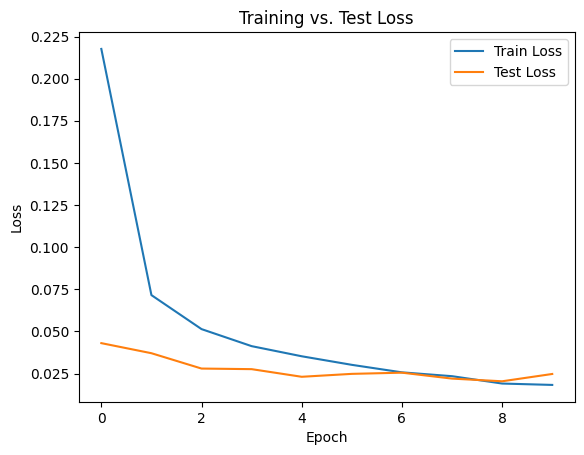

In [6]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()
plt.show()